In [2]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import numpy as np
import pandas as pd

C:\Users\SURYA B.S\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\SURYA
[nltk_data]     B.S\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Model

In [4]:
model_name = "facebook/bart-large-mnli"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )

    return theme_classifier


In [6]:
theme_classifier = load_model(device)

c:\Users\SURYA B.S\Documents\series\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
theme_list = ["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue"]

In [44]:
",".join(theme_list)

'friendship,hope,sacrifice,battle,self development,betrayal,love,dialogue'

friendship,hope,sacrifice,battle,self development,betrayal,love,dialogue

C:\Users\SURYA B.S\Documents\series\data\subtitles\Naruto Season 1 - 01.ass

C:\Users\SURYA B.S\Documents\series\stubs\output.csv

In [8]:
theme_classifier(
    "I gave him a right hook then a right jab",
    theme_list,
    multi_label = True
)

c:\Users\SURYA B.S\Documents\series\venv\Lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'sequence': 'I gave him a right hook then a right jab',
 'labels': ['battle',
  'self development',
  'hope',
  'sacrifice',
  'dialogue',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.8810246586799622,
  0.45669206976890564,
  0.07687634229660034,
  0.037723470479249954,
  0.03613840788602829,
  0.014081836678087711,
  0.005437070969492197,
  0.004093047697097063]}

# Load Dataset

In [9]:
files = glob('../data/subtitles/*.ass')

In [10]:
with open(files[0], 'r') as file:
    lines = file.readlines()
    lines = lines[27:]
    lines = [",".join(line.split(',')[9:]) for line in lines]

In [11]:
lines[:2]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n']

In [12]:
lines = [line.replace('\\N', ' ') for line in lines]

In [13]:
lines[:2]

['A long time ago, a powerful demon fox appeared with nine tails.\n',
 'With its powerful tails,\n']

In [14]:
" ".join(lines[:10])

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n"

In [15]:
# Getting episode numer
int(files[0].split("-")[-1].split('.')[0].strip())

1

In [16]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path + '/*.ass')

    scripts = []
    episode_num = []
    for path in subtitles_paths:
        
        # read lines
        with open(path, 'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines = [",".join(line.split(',')[9:]) for line in lines]
        lines = [line.replace('\\N', ' ') for line in lines]
        script = " ".join(lines)

        episode = int(path.split("-")[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode":episode_num, "script": scripts})
    return df
        

In [17]:
dataset_path = "../data/subtitles"
df = load_subtitles_dataset(dataset_path)

In [18]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


# Run Model

In [19]:
script = df.iloc[0]['script']
len(script)

10417

In [20]:
script_sentences = sent_tokenize(script)
script_sentences[:2][0]

'A long time ago, a powerful demon fox appeared with nine tails.'

In [21]:
# Batch sentence
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index: index+sentence_batch_size])
    script_batches.append(sent)

In [22]:
script_batches[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [23]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [24]:
theme_output

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'sacrifice',
   'self development',
   'hope',
   'friendship',
   'love'],
  'scores': [0.980073869228363,
   0.9396896362304688,
   0.8546874523162842,
   0.7349812388420105,
   0.7284945249557495,
   0.1990976482629776

In [25]:
# Wrangle output
# battle: [0.248942, 0.457789]

themes = {}
for output in theme_output:
    for label, score in zip(output['labels'], output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [26]:
themes

{'dialogue': [0.980073869228363, 0.9370124936103821],
 'betrayal': [0.9396896362304688, 0.6457229852676392],
 'battle': [0.8546874523162842, 0.6581294536590576],
 'sacrifice': [0.7349812388420105, 0.625882625579834],
 'self development': [0.7284945249557495, 0.867819607257843],
 'hope': [0.1990976482629776, 0.2042403519153595],
 'friendship': [0.05922291800379753, 0.08603301644325256],
 'love': [0.04026173800230026, 0.028020672500133514]}

In [27]:
def get_theme_inference(script):

    '''Takes a Script, Split it into batches, Run model on the batches,
    Then averages over the batches'''
    script_sentences = sent_tokenize(script)
    # Batch sentence
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index: index+sentence_batch_size])
        script_batches.append(sent)

    # Run model
    theme_output = theme_classifier(
        script_batches,
        theme_list,
        multi_label=True
    )

    # wrangle_output
    themes = {}
    for output in theme_output:
        for label, score in zip(output['labels'], output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key, value in themes.items()}

    return themes

In [28]:
df = df.head(2)

output_themes = df['script'].apply(get_theme_inference)

In [29]:
output_themes

0    {'dialogue': 0.9330654184023539, 'betrayal': 0...
1    {'dialogue': 0.8789064075265612, 'sacrifice': ...
Name: script, dtype: object

In [30]:
theme_df = pd.DataFrame(output_themes.to_list())
theme_df

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.933065,0.843436,0.730703,0.738851,0.786690,0.356776,0.270746,0.171008
1,0.878906,0.523089,0.614092,0.560678,0.723522,0.360577,0.199374,0.126210


In [35]:
df[theme_df.columns] = theme_df
df

,episode,script,betrayal,battle,sacrifice,self development,hope,friendship,love,dialogue
0,1,"A long time ago, a powerful demon fox appeared...",0.843436,0.730703,0.738851,0.786690,0.356776,0.270746,0.171008,0.933065
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.523089,0.614092,0.560678,0.723522,0.360577,0.199374,0.126210,0.878906


# Visualize output

In [36]:
df = df.drop('dialogue', axis=1)
df

,episode,script,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.843436,0.730703,0.738851,0.786690,0.356776,0.270746,0.171008
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.523089,0.614092,0.560678,0.723522,0.360577,0.199374,0.126210


In [39]:
theme_output = df.drop(['episode', 'script'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,betrayal,1.366525
1,battle,1.344795
2,sacrifice,1.299529
3,self development,1.510211
4,hope,0.717353
5,friendship,0.470120
6,love,0.297218


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

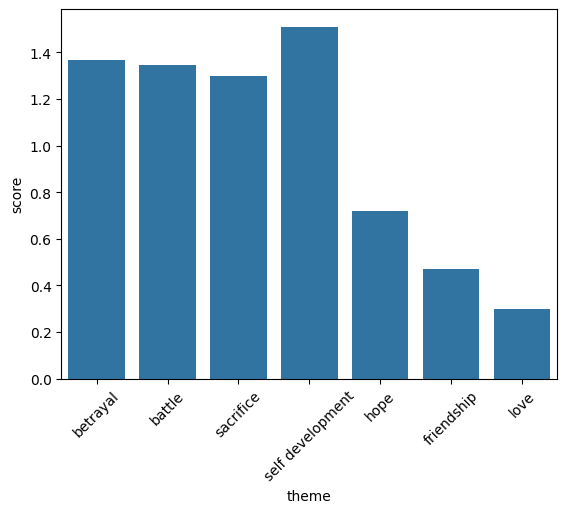

In [43]:
sns.barplot(data=theme_output, x='theme', y='score')
plt.xticks(rotation=45)
plt.show()